<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"alirezashafaei97","key":"9cb262aa0c5658ffc4eb45857c41903c"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat -p /content
!unzip /content/heartbeat.zip -d /content/heartbeat

In [0]:
import pandas as pd
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Softmax, InputLayer, concatenate, Conv1D, Flatten
from tensorflow.keras import backend as K
from random import uniform 


from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix


In [0]:
train_df=pd.read_csv('/content/heartbeat/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)

In [64]:
train_df[187]=train_df[187].astype(int)
counter=train_df[187].value_counts()
print(counter)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [0]:
trainset = train_df.values
testset = test_df.values

In [0]:
trainset = np.take(trainset,np.random.permutation(trainset.shape[0]),axis=0,out=trainset)

In [0]:
X_temp_train = trainset[:, :-1]
Y_train = trainset[:, -1:]
X_temp_test = testset[:, :-1]
Y_test = testset[:, -1:]

In [68]:
print("X_train : ", X_temp_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_temp_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (87554, 187)
Y_train :  (87554, 1)
X_test :  (21892, 187)
Y_test :  (21892, 1)


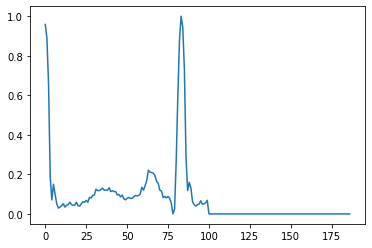

In [69]:
plt.plot(X_temp_train[7, :])
plt.show()

In [0]:

# One Hot enoding for target labels 
ohe = OneHotEncoder()
Y_train = ohe.fit_transform(Y_train.reshape(-1,1))
Y_test = ohe.transform(Y_test.reshape(-1,1))

# handle sparse matrix for keras 
Y_train = csr_matrix.toarray(Y_train)
Y_test = csr_matrix.toarray(Y_test)

In [71]:
print("X_train : ", X_temp_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_temp_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (87554, 187)
Y_train :  (87554, 5)
X_test :  (21892, 187)
Y_test :  (21892, 5)


In [72]:
Y_train[1000:1006, :]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

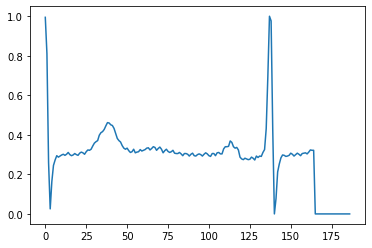

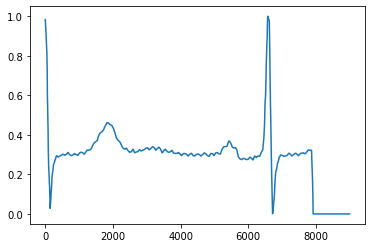

In [73]:

#### change X_train.shape from (1, 187) to (1, 9000) for transfer learning ####

X_train = np.zeros((X_temp_train.shape[0], 9000))
j = 48

for i, signal in enumerate(X_temp_train):

  for index, item in enumerate(signal):

    if index != 186:
      
      temp = np.random.uniform(signal[index], signal[index+1], 48)
      
      if (signal[index+1]) > (signal[index]) :
        temp = np.sort(temp)
      else:
        temp = -np.sort(-temp)


      X_train[i, index*j:(index+1)*(j)] = temp

    else: 
      pass


plt.plot(X_temp_train[1, :])
plt.show()
plt.plot(X_train[1, :])
plt.show()


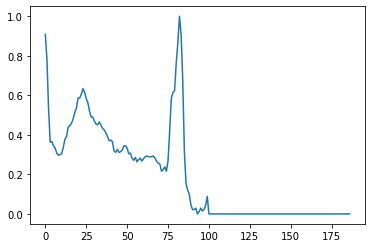

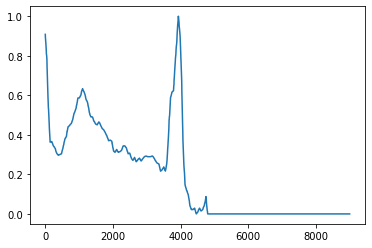

In [79]:

#### change X_test.shape from (1, 187) to (1, 9000) for transfer learning ####

X_test = np.zeros((X_temp_test.shape[0], 9000))
j = 48

for i, signal in enumerate(X_temp_test):

  for index, item in enumerate(signal):

    if index != 186:
      
      temp = np.random.uniform(signal[index], signal[index+1], 48)
      
      if (signal[index+1]) > (signal[index]) :
        temp = np.sort(temp)
      else:
        temp = -np.sort(-temp)


      X_test[i, index*j:(index+1)*(j)] = temp

    else: 
      pass


plt.plot(X_temp_test[1, :])
plt.show()
plt.plot(X_test[1, :])
plt.show()


In [80]:
print("X_train : ", X_train.shape)
print("Y_train : ", Y_train.shape)
print("X_test : ", X_test.shape)
print("Y_test : ", Y_test.shape)

X_train :  (87554, 9000)
Y_train :  (87554, 5)
X_test :  (21892, 9000)
Y_test :  (21892, 5)


In [0]:

# Load pre_trained model 

base_model = load_model('/content/drive/My Drive/Cardio/AF_Classification.h5')

# summarize model.
base_model.summary()




Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 4498, 16)     96          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 4498, 32)     4640        conv1d_51[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 4498, 32)     128         conv1d_52[0][0]                  
____________________________________________________________________________________________

In [0]:

X_input = Input(shape=(1, 187))
D1_1 = Dense(9000)(X_input)
Act1_1 = LeakyReLU()(D1_1)
print(type(Act1_1))                              

# temp = model.layers[2].output

# get_layer_output = K.function(inputs = base_model.layers[0].input, outputs = Model.layers[-5].output)
# # extract output
# old_model_output = get_layer_output(temp)



<class 'tensorflow.python.framework.ops.Tensor'>


In [0]:

X_input = Input(shape=(1, 187))
D1_1 = Dense(9000)(X_input)
Act1_1 = LeakyReLU()(D1_1)

temp = model.layers[2].output

get_layer_output = K.function(inputs = base_model.layers[0].input, outputs = Model.layers[-5].output)
# extract output
old_model_output = get_layer_output(temp)






In [0]:


X_input = Input(shape=(1, 187))
D1 = Dense(9000, activation="sigmoid")(X_input)
intermediate_from_base_model = base_model.get_layer("leaky_re_lu_67").output
merge_layer = concatenate([X_input, intermediate_from_base_model])

D2 = Dense(5)(BMO)
A1 = Softmax()(D2)

model = Model(inputs=X_input, outputs=A2)

model.summary()



TypeError: ignored

In [0]:
A = np.random.rand(1, 187)
X_input = Input(shape=(1, 187))
D =

input_layer = InputLayer(input_shape=(1, 187), name="input_1")
Out1 = Dense(5)(input_layer)
new_model = base_model(input=X_input, output=Out1)
new_model.summary()

AttributeError: ignored

In [0]:
encoding = model.layers[-5].get_output(train=False).eval({model.layers[0].input: D1})

In [0]:
X_input = Input(shape=(1, 187))
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

In [0]:
X_input = Input(shape=(1, 187))
model_output = model.input()
X = model.layers[-5].output
X_1 = Dense(256)(X)
new_model = Model(input=X_input, output=Out1)